<b>Week Five Assignment</b> 
- All questions are answered in this notebook.

In [1]:
# Import required libraries.
import pandas as pd # Library for data analysis
import numpy as np
import json # Library to handle JSON files
import requests # Library to handle requests
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from sklearn.cluster import KMeans # Import k-means for clustering.
import bs4 as bs
from bs4 import BeautifulSoup # Website scraping libraries.
from geopy.geocoders import Nominatim  # Convert an address into latitude and longitude values.
from shapely.geometry import Point
import geopandas as gpd
import lxml.html as lh
import folium

In [2]:
# GET request
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802" # Use old link
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [3]:
wiki_data

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"0bceeded-f3cd-4c78-b3bd-5e32a9cdecdf","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":1019189119,"wgRevisionId":1012118802,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Communications in Ontario",

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
# Clean up the dataframe, removing unassigned values.
toronto = toronto[toronto.Borough != 'Not assigned']
toronto = toronto[toronto.Borough !=  0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [6]:
# Check the dataframe.
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,12,100
top,M7B\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [7]:
# Get the data from url/link.
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [8]:
# View the data.
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [9]:
# Select only data where field Borough doesn't have not assigned value
raw_data_selected = data[data['Borough'] != 'Not assigned']
# Grouping Data
raw_data_selected = raw_data_selected.groupby(['Borough', 'Postal Code'], as_index=False).agg(','.join)
# Check dataframe again!
raw_data_selected.head()

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [10]:
# Replace values in Neighbourhood field with Borough where Neighbourhood is not assigned
raw_data_selected['Neighbourhood'] = np.where(raw_data_selected['Neighbourhood'] == 'Not assigned', raw_data_selected['Borough'], raw_data_selected['Neighbourhood'])
# Shape of Data
raw_data_selected.shape

(103, 3)

In [11]:
# Format column names: optional. e.g Neighbourhood vs Neighborhood, PostCode vs Postal Code.
column_titles = ['Postal Code', 'Borough','Neighbourhood']
df = raw_data_selected[column_titles]
df.head()

,Postal Code,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


In [12]:
df.shape

(103, 3)

In [13]:
# Get the geographical longitude and latitude values.
geospatial_url = "https://cocl.us/Geospatial_data"
geospatial_data = pd.read_csv(geospatial_url)
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
# Merging dataframes based on 'Postal Code'.
merged_data = pd.merge(df, geospatial_data, on = 'Postal Code')
merged_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [15]:
# Unify the coordinates
merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))
merged_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,"(43.7153834, -79.4056784)"
3,M4S,Central Toronto,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,"(43.6895743, -79.3831599)"


In [16]:
merged_data['Coordinates'] = merged_data['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(merged_data, geometry='Coordinates')
gdf.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879)
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020)
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.71538 -79.40568)
3,M4S,Central Toronto,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879)
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.68957 -79.38316)


/home/roe/anaconda3/envs/ai/lib/python3.8/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


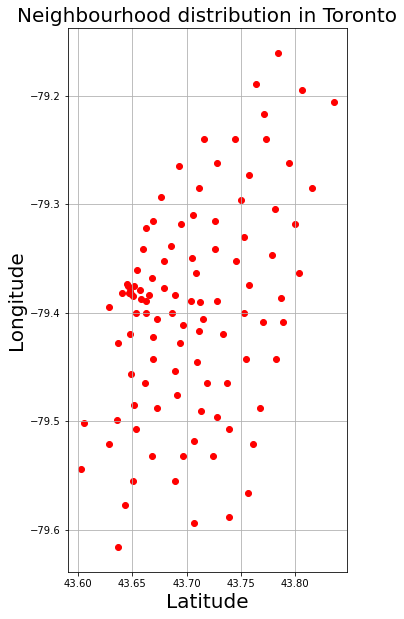

In [17]:
# Build map of Toronto.
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='green', edgecolor='black', figsize =(10, 10))
# Plot the map.
gdf.plot(ax=ax, color='red')
plt.xlabel('Latitude', fontsize = 20)
plt.ylabel('Longitude', fontsize = 20)
plt.title('Neighbourhood distribution in Toronto', fontsize = 20)
plt.grid()
plt.show()

In [70]:
# Check the number of boroughs and neighbourhoods
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(len(df['Borough'].unique()), df.shape[0]))

The dataframe has 11 boroughs and 103 neighbourhoods.


In [19]:
# Check the number of neighbourhoods per borough.
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
Toronto/York         1
West Toronto         6
York                 4
Name: Neighbourhood, dtype: int64

In [20]:
df_toronto = df[df['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True)
df_toronto.drop('index', axis=1, inplace=True)
df_toronto.head()

/home/roe/anaconda3/envs/ai/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Postal Code,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


In [21]:
print(df_toronto.groupby('Borough').count()['Neighbourhood'])

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
Toronto/York         1
West Toronto         6
Name: Neighbourhood, dtype: int64


In [22]:
df_toronto.head()

,Postal Code,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


In [23]:
# Create list with the boroughs.
boroughs = df_toronto['Borough'].unique().tolist()
lat_toronto = gdf['Latitude'].mean()
lon_toronto = gdf['Longitude'].mean()
# Geographical coordinates of Toronto.
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [24]:
# Create new map.
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=12)

# Add markers to map.
for lat, lng, borough, neighborhood in zip(gdf['Latitude'], 
                                           gdf['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [37]:
# Create 'New App' in Foursquare using your developer account to get these credentials.
CLIENT_ID = 'BLANKED OUT FOR SECURITY' # Foursquare ID.
CLIENT_SECRET = 'BLANKED OUT FOR SECURITY' # Foursquare Secret.
VERSION = '20180605' # Foursquare API version.
LIMIT = 100 # Limit of number of venues returned by Foursquare API.
radius = 500 # Define radius.

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Create the API request URL.
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request.
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Return only relevant information for each nearby venue.
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
# Get venues.
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=gdf['Latitude'],
                                longitudes=gdf['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [41]:
# Venues detailed info.
print(toronto_venues.shape)
toronto_venues.groupby('Neighbourhood').count()

(1550, 7)


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",21,21,21,21,21,21
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,61,61,61,61,61,61
Christie,16,16,16,16,16,16
Church and Wellesley,80,80,80,80,80,80
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [42]:
# Check the venue types/categories in the specified coordinates.
toronto_venues['Venue Category'].unique()[:100]

array(['Park', 'Swim School', 'Bus Line', 'Food & Drink Shop',
       'Breakfast Spot', 'Department Store', 'Hotel', 'Sandwich Place',
       'Gym / Fitness Center', 'Convenience Store', 'Dance Studio',
       'Pizza Place', 'Yoga Studio', 'Diner', 'Salon / Barbershop',
       'Restaurant', 'Spa', 'Mexican Restaurant', 'Clothing Store',
       'Coffee Shop', 'Chinese Restaurant', 'Sporting Goods Shop',
       'Fast Food Restaurant', 'Café', 'Seafood Restaurant',
       'Italian Restaurant', 'Gift Shop', 'Ice Cream Shop', 'Pet Store',
       'Rental Car Location', 'Dessert Shop', 'Indian Restaurant',
       'Sushi Restaurant', 'Thai Restaurant', 'Gym', 'Brewery',
       'Toy / Game Store', 'Greek Restaurant', 'Gas Station',
       'Farmers Market', 'Gourmet Shop', 'Pharmacy', 'Tennis Court',
       'Supermarket', 'Liquor Store', 'American Restaurant', 'Pub',
       'Fried Chicken Joint', 'Bank', 'Vietnamese Restaurant',
       'Light Rail Station', 'Bagel Shop', 'Garden', 'Trail',
     

In [46]:
# Check for 'Restaurant' venues in Toronto.
"Restaurant" in toronto_venues['Venue Category'].unique()

True

In [47]:
# Encode to prep for clustering.
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighbourhood column back to dataframe.
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column.
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

# Check shape of the new dataframe.
print(to_onehot.shape)
to_onehot.head()

(1550, 233)


,Neighbourhoods,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()
print(to_grouped.shape)
to_grouped

(40, 233)


,Neighbourhoods,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.016949,0.00000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.047619,0.000000,0.047619
2,"Business reply mail Processing Centre, South C...",0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0000,0.0000,0.071429,0.071429,0.071429,0.071429,0.214286,0.142857,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.016393,0.00000,0.000000,0.000000,0.016393,0.016393
5,Christie,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.0125,0.0125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,...,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.025000
7,"Commerce Court, Victoria Hotel",0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.00000,0.00,0.020000,0.00000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.030303,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [49]:
len(to_grouped[to_grouped["Restaurant"] > 0])

25

In [50]:
to_restaurant = to_grouped[["Neighbourhoods","Restaurant"]]
to_restaurant.head()

,Neighbourhoods,Restaurant
0,Berczy Park,0.033898
1,"Brockton, Parkdale Village, Exhibition Place",0.047619
2,"Business reply mail Processing Centre, South C...",0.066667
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.016393


In [51]:
from sklearn.cluster import KMeans
toclusters = 3 # Use 3 clusters. 

to_clustering = to_restaurant.drop(["Neighbourhoods"], 1)

# Run k-means clustering
kmeans = KMeans(n_clusters = toclusters, random_state=1)
kmeans.fit_transform(to_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2],
      dtype=int32)

In [52]:
to_merged = to_restaurant.copy()
# Add clustering labels.
to_merged["Cluster Labels"] = kmeans.labels_

to_merged.rename(columns={"Neighbourhoods": "Neighbourhood"}, inplace=True)
to_merged.head()

,Neighbourhood,Restaurant,Cluster Labels
0,Berczy Park,0.033898,2
1,"Brockton, Parkdale Village, Exhibition Place",0.047619,2
2,"Business reply mail Processing Centre, South C...",0.066667,2
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.016393,0


In [53]:
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhood")

print(to_merged.shape)
to_merged.head()

(1550, 9)


,Neighbourhood,Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.033898,2,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.033898,2,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.033898,2,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.033898,2,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar
0,Berczy Park,0.033898,2,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [54]:
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

,Neighbourhood,Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
17,"Kensington Market, Chinatown, Grange Park",0.00,0,43.653206,-79.400049,Ozzy's Burger,43.655191,-79.402610,Burger Joint
13,"Garden District, Ryerson",0.01,0,43.657162,-79.378937,Nordstrom Ebar,43.654649,-79.380574,Coffee Shop
13,"Garden District, Ryerson",0.01,0,43.657162,-79.378937,Trattoria Mercatto,43.654453,-79.380974,Italian Restaurant
13,"Garden District, Ryerson",0.01,0,43.657162,-79.378937,Uncle Tetsu's Cheesecake (Uncle Tetsu's Japane...,43.656063,-79.383695,Dessert Shop
13,"Garden District, Ryerson",0.01,0,43.657162,-79.378937,Hard Candy Fitness,43.659556,-79.382440,Gym / Fitness Center


In [68]:
map_clusters = folium.Map(location = [lat_toronto, lon_toronto], zoom_start = 10)

# Set color scheme for the clusters and add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'yellow'
markers_colors[4] = 'cyan'
markers_colors[5] = 'black'
for lat, lon, cluster in zip(to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Cluster Labels']):
     
    folium.features.CircleMarker([lat, lon],
                                    radius = 5,       
                                    color = markers_colors[cluster],
                                    fill_color = markers_colors[cluster],
                                    fill_opacity = 0.5).add_to(map_clusters)       
map_clusters
#plt.savefig('Restaurant_Cluster.jpeg', format = 'jpeg', dpi = 500)

In [56]:
# Check Cluster 0
to_merged.loc[(to_merged['Cluster Labels'] ==0) & (to_merged['Venue Category'] == 'Restaurant') ]

,Neighbourhood,Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,"Garden District, Ryerson",0.010000,0,43.657162,-79.378937,Jack Astor's Bar & Grill,43.656019,-79.380326,Restaurant
30,St. James Town,0.024096,0,43.651494,-79.375418,Bannock,43.652101,-79.381178,Restaurant
24,"Regent Park, Harbourfront",0.022222,0,43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
30,St. James Town,0.024096,0,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
37,"The Danforth West, Riverdale",0.024390,0,43.679557,-79.352188,Rikkochez,43.677267,-79.353274,Restaurant
4,Central Bay Street,0.016393,0,43.657952,-79.387383,Teriyaki Experience,43.659884,-79.387879,Restaurant


In [57]:
# Check Cluster 1
to_merged.loc[(to_merged['Cluster Labels'] ==1) & (to_merged['Venue Category'] == 'Restaurant') ]

,Neighbourhood,Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
20,"Moore Park, Summerhill East",0.666667,1,43.689574,-79.38316,Reds,43.692816,-79.384504,Restaurant
20,"Moore Park, Summerhill East",0.666667,1,43.689574,-79.38316,1 Kitchen,43.686389,-79.382160,Restaurant


In [62]:
# Check Cluster 2
to_merged.loc[(to_merged['Cluster Labels'] ==2) & (to_merged['Venue Category'] == 'Restaurant') ]

,Neighbourhood,Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
38,"Toronto Dominion Centre, Design Exchange",0.030000,2,43.647177,-79.381576,Victoria's Restaurant,43.649298,-79.376431,Restaurant
39,"University of Toronto, Harbord",0.031250,2,43.662696,-79.400049,Rasa,43.662757,-79.403988,Restaurant
25,"Richmond, Adelaide, King",0.043478,2,43.650571,-79.384568,Bymark,43.647217,-79.381252,Restaurant
25,"Richmond, Adelaide, King",0.043478,2,43.650571,-79.384568,Canoe,43.647452,-79.381320,Restaurant
25,"Richmond, Adelaide, King",0.043478,2,43.650571,-79.384568,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
31,"St. James Town, Cabbagetown",0.065217,2,43.667967,-79.367675,El Charro,43.667606,-79.369490,Restaurant
32,Stn A PO Boxes,0.030303,2,43.646435,-79.374846,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
31,"St. James Town, Cabbagetown",0.065217,2,43.667967,-79.367675,Murgatroid,43.667381,-79.369311,Restaurant
31,"St. James Town, Cabbagetown",0.065217,2,43.667967,-79.367675,The Pear Tree,43.664904,-79.368246,Restaurant
32,Stn A PO Boxes,0.030303,2,43.646435,-79.374846,Victoria's Restaurant,43.649298,-79.376431,Restaurant


<b>Summary of findings</b>
- Most restaurants are located in Cluster 2.
- The specific locations include: King, Victoria Hotel and Underground City.
- This is the best location to set up the sommelier consultancy and training establishment as most of the market/target is located in this sector.
- Cluster 1 has the least number of restaurants (only 2) and as such may affect the marketing of the business. 
- There are fewer potential clients in Cluster 1.
- The specific locations to avoid may be: Ryerson, and Central Bay Street.
- St James may need further research as it shows up in both Cluster 1 and Cluster 2.
- This research may be improved by splitting up the restaurants according to the type of restaurants, e.g African, European and Asian.
- This is because in some cultures wind and food pairings are more popular.